<a href="https://colab.research.google.com/github/emilyswitzer/celeb-heights/blob/main/Celebs_CNN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

In [3]:
!unzip "/content/train.zip" -d "/"

Archive:  /content/train.zip
   creating: /content/205/
   creating: /content/205/169/
  inflating: /content/205/169/Angelica Celaya.jpg  
  inflating: /content/205/169/Annabel Croft.jpg  
  inflating: /content/205/169/Emmy Rossum.jpg  
  inflating: /content/205/169/Stacy Martin.jpg  
  inflating: /content/205/169/Anna Diop.jpg  
  inflating: /content/205/169/Christian Antidormi.jpg  
  inflating: /content/205/169/Omid Abtahi.jpg  
  inflating: /content/205/169/Anna Konkle.jpg  
  inflating: /content/205/169/Sara Sohn.jpg  
  inflating: /content/205/169/Anabelle Acosta.jpg  
  inflating: /content/205/169/Daisy Ridley.jpg  
  inflating: /content/205/169/Damon Herriman.jpg  
  inflating: /content/205/169/Nathalie Emmanuel.jpg  
  inflating: /content/205/169/Annie Parisse.jpg  
  inflating: /content/205/169/Ariane Rinehart.jpg  
  inflating: /content/205/169/Anne Hathaway.jpg  
  inflating: /content/205/169/Annet Mahendru.jpg  
  inflating: /content/205/169/Davina McCall.jpg  
  inflating

In [96]:
!zip -r /content/file.zip /content/205

  adding: content/205/ (stored 0%)
  adding: content/205/169/ (stored 0%)
  adding: content/205/169/Angelica Celaya.jpg (deflated 11%)
  adding: content/205/169/Annabel Croft.jpg (deflated 11%)
  adding: content/205/169/Emmy Rossum.jpg (deflated 10%)
  adding: content/205/169/Stacy Martin.jpg (deflated 13%)
  adding: content/205/169/Anna Diop.jpg (deflated 10%)
  adding: content/205/169/Christian Antidormi.jpg (deflated 12%)
  adding: content/205/169/Omid Abtahi.jpg (deflated 16%)
  adding: content/205/169/Anna Konkle.jpg (deflated 14%)
  adding: content/205/169/Sara Sohn.jpg (deflated 10%)
  adding: content/205/169/Anabelle Acosta.jpg (deflated 15%)
  adding: content/205/169/Daisy Ridley.jpg (deflated 10%)
  adding: content/205/169/Damon Herriman.jpg (deflated 12%)
  adding: content/205/169/Nathalie Emmanuel.jpg (deflated 11%)
  adding: content/205/169/Annie Parisse.jpg (deflated 77%)
  adding: content/205/169/Ariane Rinehart.jpg (deflated 13%)
  adding: content/205/169/Anne Hathaway.

In [17]:
!unzip "/content/205.zip" -d "/content/205"

Archive:  /content/205.zip
  inflating: /content/205/106/Beetlejuice.jpg  
  inflating: /content/205/106/Billy Barty.jpg  
  inflating: /content/205/106/Danny Woodburn.jpg  
  inflating: /content/205/106/David Rappaport.jpg  
  inflating: /content/205/106/Deep Roy.jpg  
  inflating: /content/205/106/Dylan 'Hornswoggle' Postl.jpg  
  inflating: /content/205/106/Herve Villechaize.jpg  
  inflating: /content/205/106/Jason Acuna.jpg  
  inflating: /content/205/106/Jimmy Vee.jpg  
  inflating: /content/205/106/Kenny Baker.jpg  
  inflating: /content/205/106/Kiran Shah.jpg  
  inflating: /content/205/106/Leigh Gill.jpg  
  inflating: /content/205/106/Martin Klebba.jpg  
  inflating: /content/205/106/Meredith Eaton.jpg  
  inflating: /content/205/106/Michael J Anderson.jpg  
  inflating: /content/205/106/Peter Dinklage.jpg  
  inflating: /content/205/106/Phil Fondacaro.jpg  
  inflating: /content/205/106/Rusty Goffe.jpg  
  inflating: /content/205/106/Sam Humphrey.jpg  
  inflating: /content/

In [4]:
import pathlib
import glob
import cv2
#data_dir = "train/"
data_dir = "/content/205"
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3215


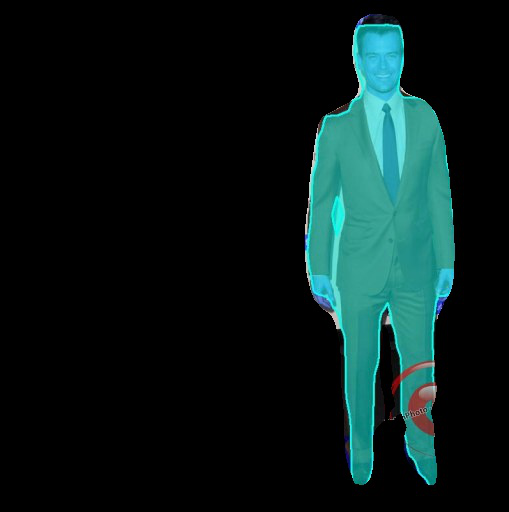

In [6]:
person = list(data_dir.glob('191/*'))
PIL.Image.open(str(person[10]))


In [8]:
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')

In [10]:
import cv2
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

def load_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

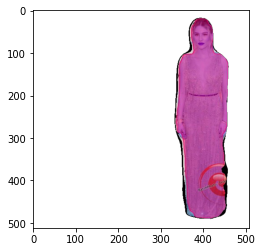

In [11]:
import numpy as np
deeplab_model = load_model()
foreground, bin_mask = remove_background(deeplab_model, '/content/205/160/Sofia Hublitz.jpg')
plt.imshow(foreground)

In [95]:
import glob
import cv2 
import os
from os.path import basename
from imutils import paths
import imutils
import argparse
deeplab_model = load_model()

path = "/content/205/81/*"
newpath = "/content/205/81/"

for file in glob.glob(path):
 
   fil = basename(file)
   filname = os.path.splitext(fil)[0]
   foreground, bin_mask = remove_background(deeplab_model, file)

   cv2.imwrite(newpath+filname+'.jpg', foreground)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


# Load data using a Keras utility


## Create a dataset

In [12]:
from keras.callbacks import ModelCheckpoint

In [13]:
batch_size = 8
#img_height = 256
#img_width = 211

img_height = 512
img_width = 509

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
 # color_mode="grayscale",
  batch_size=batch_size)


Found 3215 files belonging to 68 classes.
Using 1929 files for training.


In [15]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
 #color_mode="grayscale",
  batch_size=batch_size)

Found 3215 files belonging to 68 classes.
Using 1286 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)

['106', '109', '111', '114', '116', '119', '121', '125', '127', '129', '130', '132', '139', '146', '147', '148', '149', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '177', '178', '179', '180', '181', '182', '183', '184', '185', '188', '190', '191', '192', '193', '194', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '81']


## Visualize the data



In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 512, 509, 3)
(8,)


## Standardize the data

The RGB channel values are in the `[0, 255]` range. To keep input values small  standardize values to be in the `[0, 1]` range.

In [18]:
normalization_layer = layers.Rescaling(1./255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# Create the model



## Overfitting

## Data augmentation

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

#Create the model with Overfitting Solutions

In [21]:
num_classes = len(class_names)


model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
 
  
])

In [122]:
num_classes = len(class_names)


model = Sequential([
  #data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3,padding='same', activation='relu'),
  layers.Conv2D(32, 3,padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3,padding='same', activation='relu'),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3,padding='same', activation='relu'),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(num_classes),
])

In [ ]:
checkpoint = ModelCheckpoint('model.h5',  # model filename
                             monitor='val_loss', # quantity to monitor
                             verbose=0, # verbosity - 0 or 1
                             save_best_only= True, # The latest best model will not be overwritten
                             mode='auto') # The decision to overwrite model is made 
                                          # automatically depending on the quantity to monitor 

x = list/ array of images
y - list/array of number (height)

## Compile and train the model

In [126]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
             metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 512, 509, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 512, 509, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 509, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 254, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 254, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 127, 32)     0         
 2D)                                                  

In [22]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
 
 # callbacks=[checkpoint],
  epochs=epochs
)

Epoch 1/50
242/242 [==============================] - 109s 447ms/step - loss: 4.2095 - accuracy: 0.0285 - val_loss: 4.1644 - val_accuracy: 0.0327
Epoch 2/50
242/242 [==============================] - 109s 449ms/step - loss: 4.1260 - accuracy: 0.0363 - val_loss: 4.0756 - val_accuracy: 0.0428
Epoch 3/50
242/242 [==============================] - 113s 467ms/step - loss: 4.0624 - accuracy: 0.0399 - val_loss: 4.0346 - val_accuracy: 0.0459
Epoch 4/50
242/242 [==============================] - 111s 460ms/step - loss: 4.0246 - accuracy: 0.0456 - val_loss: 3.9954 - val_accuracy: 0.0474
Epoch 5/50
242/242 [==============================] - 110s 457ms/step - loss: 3.9824 - accuracy: 0.0399 - val_loss: 3.9644 - val_accuracy: 0.0490
Epoch 6/50
242/242 [==============================] - 108s 446ms/step - loss: 3.9459 - accuracy: 0.0482 - val_loss: 3.9484 - val_accuracy: 0.0498
Epoch 7/50
242/242 [==============================] - 112s 464ms/step - loss: 3.9136 - accuracy: 0.0467 - val_loss: 3.9814 -

## Visualize training results


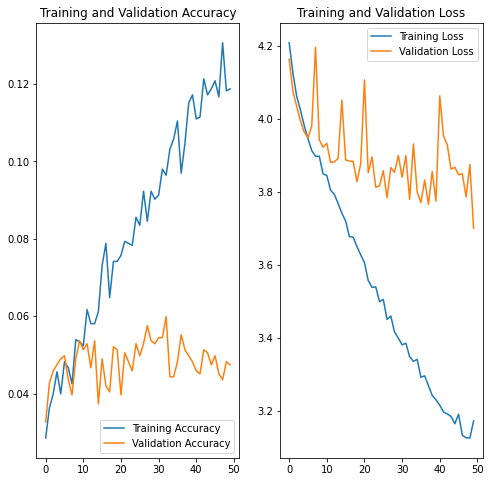

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on unseen data

In [31]:
!unzip "/content/unseen2.zip" -d "/content/unseen"

Archive:  /content/unseen2.zip
   creating: /content/unseen/content/unseen2/
  inflating: /content/unseen/content/unseen2/139.jpg  
  inflating: /content/unseen/content/unseen2/198.jpg  
  inflating: /content/unseen/content/unseen2/192.jpg  
  inflating: /content/unseen/content/unseen2/157.jpg  
  inflating: /content/unseen/content/unseen2/194.jpg  
  inflating: /content/unseen/content/unseen2/179.jpg  
  inflating: /content/unseen/content/unseen2/155.jpg  
  inflating: /content/unseen/content/unseen2/206.jpg  
  inflating: /content/unseen/content/unseen2/153.jpg  
  inflating: /content/unseen/content/unseen2/148.jpg  
  inflating: /content/unseen/content/unseen2/166.jpg  
  inflating: /content/unseen/content/unseen2/106.jpg  
  inflating: /content/unseen/content/unseen2/201.jpg  
  inflating: /content/unseen/content/unseen2/189.jpg  
  inflating: /content/unseen/content/unseen2/109.jpg  
  inflating: /content/unseen/content/unseen2/161.jpg  
  inflating: /content/unseen/content/unseen

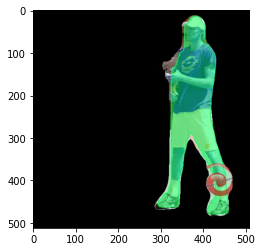

The person is 14.37 percent 205 cm 


In [39]:
import matplotlib.image as mpimg
img = mpimg.imread('/content/Kevin Anderson.jpg')
imgplot = plt.imshow(img)
plt.show()
sunflower_path = '/content/Kevin Anderson.jpg'

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])




print(
    "The person is {:.2f} percent {} cm "
    .format(100 * np.max(score),class_names[np.argmax(score)])
)